<a href="https://colab.research.google.com/github/ChristineLong/-One-sample-propotion-test/blob/master/cash_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cash App Take home assignment

Please note that this is just a notebook to walk through the process. To make it more user friendly, please use the clean version in my private git repo.

### Packages and configurations

Configure

In [ ]:
# mount google drive for raw files
from google.colab import drive
drive.mount('/content/drive')  #Please check whether the correct audio files are in your google drive before mounting

# set random seed to ensure reproducibility using pre-trained model
import random
random.seed(0)     

Mounted at /content/drive


Dependent packages

In [ ]:
import os
import numpy as np
from IPython.display import Audio
from IPython.display import clear_output
from scipy.io import wavfile

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import json
import math
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [ ]:
# Set to True if we are in colaboratory of False elsewere
colaboratory = True

if colaboratory:
    # Load the calc module
    !rm calc.*
    !wget https://raw.githubusercontent.com/R6500/Python-bits/master/Modules/calc.py

#Import the module
import calc

# Erase output after import
clear_output()

# Check loaded module
try:
    print('calc version: ',calc.version)
except:
    print('Error loading the calc module')

calc version:  2/7/2018B


### Data import, preparation and exploration

Load an example file to explore

Sample rate: 44100 Hz
Total time: 3.0998866213151928 s


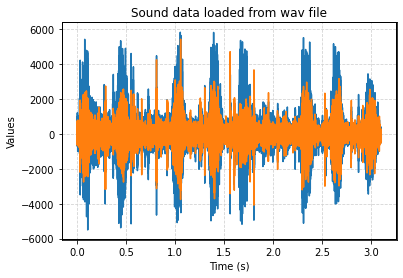

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


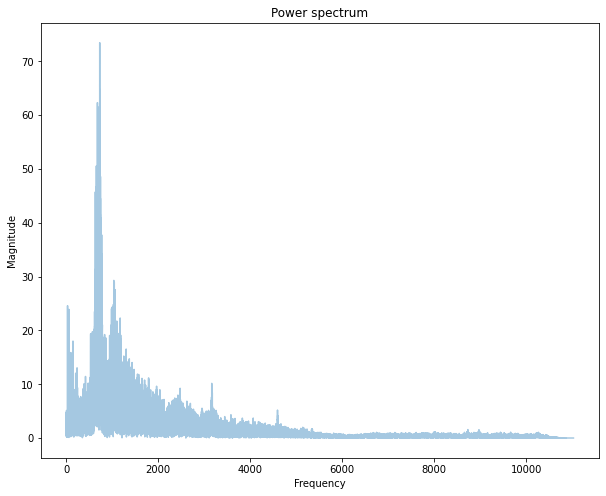

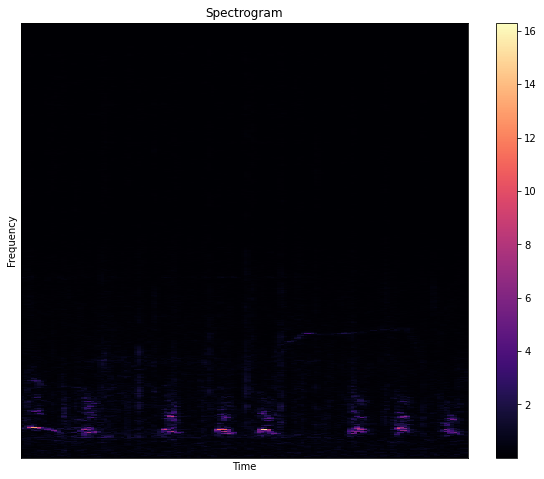

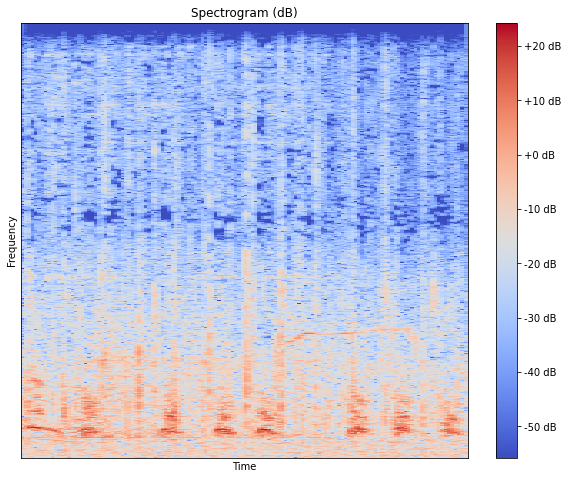

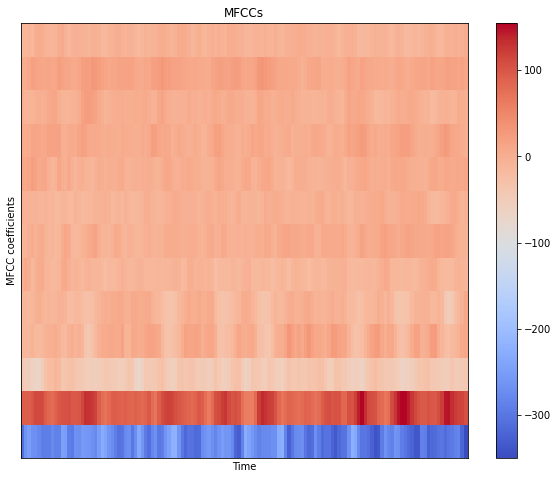

In [ ]:
FIG_SIZE = (10,8)

file = 'drive/MyDrive/cashapp_audios/100-3.wav'

# load audio file with Librosa
signal, sample_rate = librosa.load(file, sr=22050)

#basic info
calc.setColaboratory(colaboratory)
data = wavfile.read(file)

framerate = data[0]
sounddata = data[1]
time      = np.arange(0,len(sounddata))/framerate

# Show basic information about the object
print('Sample rate:',framerate,'Hz')
print('Total time:',len(sounddata)/framerate,'s')

# Show the sound data
calc.plot11(time,sounddata,"Sound data loaded from wav file","Time (s)","Values")


# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")


# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")


# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

As we can see from 100-3, there are two types of audio, blue (larger amplitude) is background noise and orange (smaller amplitude) is bark. However, bark is actually the target info. If we denoising the audio, we might lose the target information. 

In [ ]:
!sudo apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


### Modeling and Evaluation

Based on the exploration result, we can conclude that:
1. Denoising or not: As shown in exploration with 100-3, if we denoising the audio, we might lose the target information. Therefore, we do not denoising the raw data. Please note this is specific to this training data.
2. Segment or not: the videos are rather short, probably already clipped to contain target info. If segment the video, the target information may not be presented in some of the segments. Therefore I didn't segment.
3. Too short: some videos are <= 1s but still contain target info (such as bark or siren), so we shouldn't simply remove it

Model type:
1. Target info available: supervised learning
2. MLP vs. CNN vs. CRNN: Considering model performance, I prefer CNN and CRNN. But whether we need RNN is a problem. Some types of audio do not need RNN (bark, gunfire, etc.) as snipets are less sequential, but some types of audio (children speaking, music) are the opposite. Therefore I used CRNN (CNN+LSTM) on this data. 

For testing, use first few (filenames[:200])

In [ ]:
DATASET_PATH = "drive/MyDrive/cashapp_audios/" # change this to your own folder!!
JSON_PATH = "data_10.json"
SAMPLE_RATE = 44100
TRACK_DURATION = 4                              # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return: None
        """

    # dictionary to store labels and MFCCs
    data = {
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        for f in filenames[:200]:
          # save target label (i.e., last num of filename)
          target = int(f.split(".")[0].split("-")[-1])
          
          # load audio file
          file_path = os.path.join(dirpath, f)
          signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

          # process all segments of audio file
          for d in range(num_segments):

              # calculate start and finish sample for current segment
              start = samples_per_segment * d
              finish = start + samples_per_segment

              # extract mfcc
              mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
              mfcc = mfcc.T

              # store only mfcc feature with expected number of vectors
              if len(mfcc) == num_mfcc_vectors_per_segment:
                  data["mfcc"].append(mfcc.tolist())
                  data["labels"].append(target)
                  print("{}, segment:{}".format(file_path, d+1))

      # save MFCCs to json file
    with open(json_path, "w") as fp:
      json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=1)

drive/MyDrive/cashapp_audios/1253-4.wav, segment:1
drive/MyDrive/cashapp_audios/1258-4.wav, segment:1
drive/MyDrive/cashapp_audios/1245-4.wav, segment:1
drive/MyDrive/cashapp_audios/1441-6.wav, segment:1
drive/MyDrive/cashapp_audios/1446-6.wav, segment:1
drive/MyDrive/cashapp_audios/1448-6.wav, segment:1
drive/MyDrive/cashapp_audios/1440-6.wav, segment:1
drive/MyDrive/cashapp_audios/1447-6.wav, segment:1
drive/MyDrive/cashapp_audios/1260-4.wav, segment:1
drive/MyDrive/cashapp_audios/1259-4.wav, segment:1
drive/MyDrive/cashapp_audios/1444-6.wav, segment:1
drive/MyDrive/cashapp_audios/1443-6.wav, segment:1
drive/MyDrive/cashapp_audios/1449-6.wav, segment:1
drive/MyDrive/cashapp_audios/1442-6.wav, segment:1
drive/MyDrive/cashapp_audios/1445-6.wav, segment:1
drive/MyDrive/cashapp_audios/1915-0.wav, segment:1
drive/MyDrive/cashapp_audios/1918-0.wav, segment:1
drive/MyDrive/cashapp_audios/1919-0.wav, segment:1
drive/MyDrive/cashapp_audios/1920-0.wav, segment:1
drive/MyDrive/cashapp_audios/19

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 343, 11, 32)       320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 172, 6, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 172, 6, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 170, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 85, 2, 32)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 85, 2, 32)         128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 84, 1, 32)        

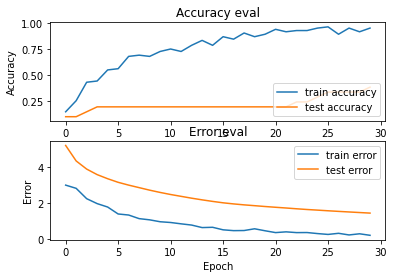

2/2 - 0s - loss: 1.7426 - accuracy: 0.3056

Test accuracy: 0.3055555522441864
Target: 0, Predicted label: [7]


In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[10]
    y_to_predict = y_test[10]

    # predict sample
    predict(model, X_to_predict, y_to_predict)

### Result and interpretation

### Future direction

If more time was given, the analyses can be further improved in the following aspects:
1. Instead of a simple CNN, we can try other types such as ResNet to achieve a higher accuracy;
2. 
